## Warmup
1.  The  starter  code  provides  an  expert  policy  for  each  of  the  MuJoCo  tasks  in  OpenAI  gym  (See
run
expert.py
).   Generate  roll-outs  from  the  provided  policies,  and  implement  behavioral  cloning.
Run behavioral cloning (BC) on the Hopper-v1 environment, and report a learning curve plotting the
loss function for the behavior cloning objective versus number of learning iterations.  Your plot should
show the (training) loss as a function of the number of gradient steps, and the loss should be improving
over time.  However, there is no other requirement for the warmup – you do not have to report any
measure of final performance, just demonstrate that the network is training and the loss is improving

In [21]:
import gym
 
env = gym.make('Ant-v1')

[2017-11-06 19:23:14,750] Making new env: Ant-v1


In [22]:
import time
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

### Feed forward nn

In [23]:
class FFN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2,output_size):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(x.size(0), -1)
    
ffn = FFN(111, 128, 64,8)

In [24]:
criterion = torch.nn.MSELoss()

learning_rate = 0.01

# Training function
def train_ffn(states_tensor, actions_tensor):
    tmp_loss = 0
    
    ffn.zero_grad()

    output = ffn(states_tensor)               # Predict action
    loss = criterion(output, actions_tensor)  # Calculate error
    tmp_loss += loss.data[0]
    loss.backward()                              # Error backpropagation

    for p in ffn.parameters():                   # Update net's parameters
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, tmp_loss 

In [25]:
# n_iters = 100
# print_every = 10

# all_losses = []
# start = time.time()

# for iter in range(1, n_iters + 1):
#     output, loss = train_ffn(*training_batch(190))
#     all_losses.append(loss)

#     if iter % print_every == 0:
#         print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
        
# plt.plot(all_losses)
# plt.ylabel('Loss')
# plt.xlabel('time');

In [26]:
#!/usr/bin/env python

"""
Code to load an expert policy and generate roll-out data for behavioral cloning.
Example usage:
    python run_expert.py experts/Humanoid-v1.pkl Humanoid-v1 --render \
            --num_rollouts 20

Author of this script and included expert policies: Jonathan Ho (hoj@openai.com)
"""

import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import pandas as pd

def learn_imitate():
#    import argparse
#     parser = argparse.ArgumentParser()
#     parser.add_argument('expert_policy_file', type=str)
#     parser.add_argument('envname', type=str)
#     parser.add_argument('--render', action='store_true')
#     parser.add_argument("--max_timesteps", type=int)
#     parser.add_argument('--num_rollouts', type=int, default=20,
#                         help='Number of expert roll outs')
#     args = parser.parse_args()
    args = pd.Series({
        'expert_policy_file':'experts/Ant-v1.pkl',
        'envname':'Ant-v1',
        'max_timesteps': None,
        'num_rollouts':40,
        'render': False
    })
    
    print('loading and building expert policy')
    target_policy_fn = load_policy.load_policy(args.expert_policy_file)
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()

        import gym
        env = gym.make(args.envname)
        max_steps = args.max_timesteps or env.spec.timestep_limit

        returns = []
        errors = []
        observations = []
        actions = []
        for i in range(args.num_rollouts):
            print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = target_policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                
                if args.render:
                    env.render()
                if steps % 100 == 0: 
                    _, error = train_ffn(Variable(torch.Tensor(observations[-100:])), 
                                     Variable(torch.Tensor(np.array(actions[-100:])[:,0,:]))
                                    )
                    print("%i/%i, Error %f"%(steps, max_steps,error))
                    errors.append(error)
                    
                    
                if steps >= max_steps:
                    break
            returns.append(totalr)

        print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))

        expert_data = {'observations': np.array(observations),
                       'actions': np.array(actions)}
        
    return returns,errors
    
returns,errors = learn_imitate()

loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-06 19:23:15,793] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-06 19:23:15,805] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-06 19:23:15,823] Making new env: Ant-v1


iter 0
100/1000, Error 0.112767
200/1000, Error 0.098844
300/1000, Error 0.095998
400/1000, Error 0.103622
500/1000, Error 0.098546
600/1000, Error 0.100390
700/1000, Error 0.096899
800/1000, Error 0.094539
900/1000, Error 0.097980
1000/1000, Error 0.097167
iter 1
100/1000, Error 0.108428
200/1000, Error 0.097352
300/1000, Error 0.090646
400/1000, Error 0.104308
500/1000, Error 0.089921
600/1000, Error 0.102071
700/1000, Error 0.098681
800/1000, Error 0.089887
900/1000, Error 0.095627
1000/1000, Error 0.097455
iter 2
100/1000, Error 0.104190
200/1000, Error 0.100984
300/1000, Error 0.081893
400/1000, Error 0.092880
500/1000, Error 0.082184
600/1000, Error 0.083112
700/1000, Error 0.090050
800/1000, Error 0.080770
900/1000, Error 0.092979
1000/1000, Error 0.086808
iter 3
100/1000, Error 0.107826
200/1000, Error 0.093783
300/1000, Error 0.083700
400/1000, Error 0.091793
500/1000, Error 0.090702
600/1000, Error 0.074494
700/1000, Error 0.083993
800/1000, Error 0.083046
900/1000, Error 0.0

600/1000, Error 0.046207
700/1000, Error 0.053620
800/1000, Error 0.064682
900/1000, Error 0.050767
1000/1000, Error 0.052413
iter 33
100/1000, Error 0.069986
200/1000, Error 0.048453
300/1000, Error 0.064659
400/1000, Error 0.057163
500/1000, Error 0.050455
600/1000, Error 0.056308
700/1000, Error 0.062880
800/1000, Error 0.048876
900/1000, Error 0.052109
1000/1000, Error 0.056232
iter 34
100/1000, Error 0.065272
200/1000, Error 0.059545
300/1000, Error 0.052083
400/1000, Error 0.052293
500/1000, Error 0.048025
600/1000, Error 0.063053
700/1000, Error 0.051486
800/1000, Error 0.048288
900/1000, Error 0.054684
1000/1000, Error 0.047729
iter 35
100/1000, Error 0.067234
200/1000, Error 0.053952
300/1000, Error 0.047504
400/1000, Error 0.051411
500/1000, Error 0.068719
600/1000, Error 0.054071
700/1000, Error 0.050277
800/1000, Error 0.056441
900/1000, Error 0.050785
1000/1000, Error 0.054621
iter 36
100/1000, Error 0.055524
200/1000, Error 0.044495
300/1000, Error 0.050604
400/1000, Erro

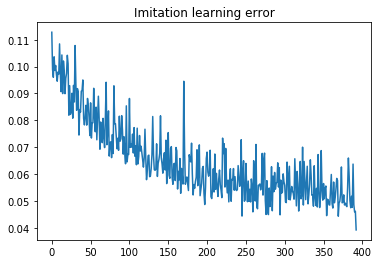

In [27]:
plt.plot(errors)
plt.title('Imitation learning error')

In [32]:
#Evaluate learned policy
def evaluate_imitate():
#    import argparse
#     parser = argparse.ArgumentParser()
#     parser.add_argument('expert_policy_file', type=str)
#     parser.add_argument('envname', type=str)
#     parser.add_argument('--render', action='store_true')
#     parser.add_argument("--max_timesteps", type=int)
#     parser.add_argument('--num_rollouts', type=int, default=20,
#                         help='Number of expert roll outs')
#     args = parser.parse_args()
    args = pd.Series({
        'envname':'Ant-v1',
        'max_timesteps': None,
        'num_rollouts':10,
        'render': False
    })
    


    env = gym.make(args.envname)
    max_steps = args.max_timesteps or env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(args.num_rollouts):
#         print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = ffn(Variable(torch.Tensor(obs))).data.numpy()  
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1

            if args.render:
                env.render()

            if steps >= max_steps:
                break
#         print(totalr)
        returns.append(totalr)

#     print('returns', returns)
    print('mean return', np.mean(returns))
    print('std of return', np.std(returns))

       
print('Trained imitation model evaluation')
evaluate_imitate()

[2017-11-06 19:47:39,155] Making new env: Ant-v1


Trained imitation model evaluation
mean return 950.663896912
std of return 2.81017548212
